In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from psiam_tied_no_dv_map_utils import psiam_tied_data_gen_wrapper, up_RTs_fit_single_t_fn, down_RTs_fit_single_t_fn, up_RTs_fit_fn, down_RTs_fit_fn
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from scipy.integrate import trapezoid as trapz
from scipy.integrate import quad


In [2]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


ABL_arr = df['ABL'].unique()
ABL_arr.sort()

ILD_arr = df['ILD'].unique()
ILD_arr.sort()

t_stim_arr = df['intended_fix'].values


In [3]:
# psiam_tied_data_gen_wrapper(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda,\
#  T_0, theta_E, Z_E, t_stim_arr, t_A_aff, t_E_aff, t_motor, dt)

V_A  = 1.6
theta_A = 2.2
rate_lambda = 0.1
T_0 = 0.1 * 1e-3
theta_E = 40
t_A_aff = -220  * 1e-3
t_E_aff = 30 * 1e-3
t_motor = 40 * 1e-3
dt = 1e-4


# tacho theory

/tmp/ipykernel_363112/3112407291.py:14: RuntimeWarning: invalid value encountered in scalar divide
  tacho[ti] = p_up / (p_up + p_down)


Text(0.5, 1.0, 'for stim time = 0.25, ABL = 40, ILD = 3')

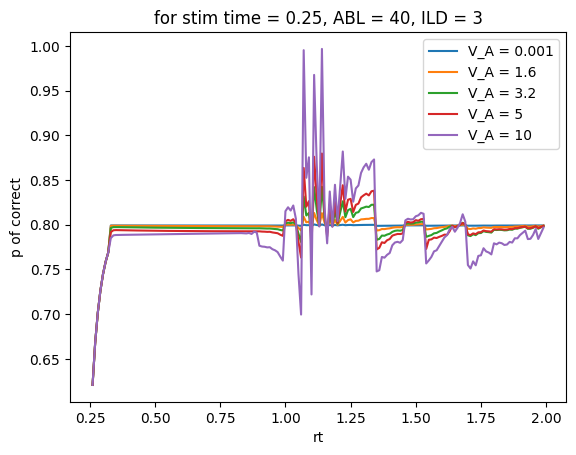

In [7]:
V_A_vals = [0.001, 1.6, 3.2, 5, 10]
ABL = 40
ILD = 3
t_stim = 0.25
K_max = 10
Z_E = 0
bin_size = 0.01
for idx,V_A in enumerate(V_A_vals):
    t_pts = np.arange(0, 2, bin_size)
    tacho = np.zeros_like(t_pts)
    for ti, t in enumerate(t_pts):
        p_up = up_RTs_fit_single_t_fn(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)
        p_down = down_RTs_fit_single_t_fn(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)
        tacho[ti] = p_up / (p_up + p_down)

    
    plt.plot(t_pts, tacho, label=f'V_A = {V_A}')

plt.legend()
plt.xlabel('rt')
plt.ylabel('p of correct')
plt.title(f'for stim time = {t_stim}, ABL = {ABL}, ILD = {ILD}')
# plt.xlim(0,1)

# theory check

Simulating for V_A = 0.6


  0%|          | 0/500000 [00:00<?, ?it/s]

Simulating for V_A = 1.6


  0%|          | 0/500000 [00:00<?, ?it/s]

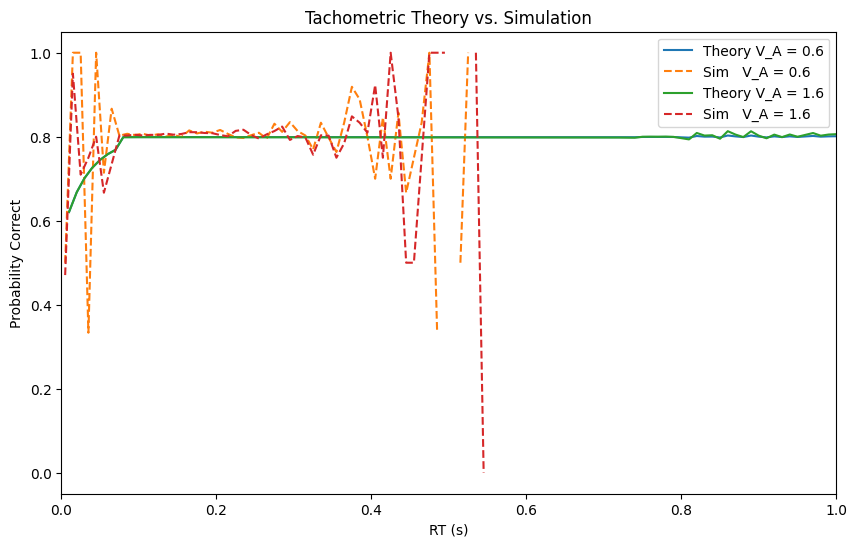

In [18]:
V_A_vals = [0.6, 1.6]
ABL = 40
ILD = 3
t_stim = 0.25
K_max = 10
Z_E = 0
bin_size = 0.01


ABL_arr = [ABL]
ILD_arr = [ILD]
t_stim_arr = [t_stim]

# Generate Simulation Results for each V_A
N_sim = int(5e5)
sim_results_dict = {}

for V_A in V_A_vals:
    print(f'Simulating for V_A = {V_A}')
    sim_results = Parallel(n_jobs=10)(
        delayed(psiam_tied_data_gen_wrapper)(
            V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0,
            theta_E, Z_E, t_stim_arr, t_A_aff, t_E_aff, t_motor, dt
        ) 
        for _ in tqdm(range(N_sim))
    )
    # Filter 
    sim_results_valid = [res for res in sim_results if res['rt'] > res['t_stim']]
    sim_results_valid_df = pd.DataFrame(sim_results_valid)
    sim_results_dict[V_A] = sim_results_valid_df

# Plot everything (theory + simulation) on a single figure
plt.figure(figsize=(10, 6))

for V_A in V_A_vals:
    # -------------------------
    # 3A) Theoretical Tachometric Curve
    # -------------------------
    t_pts = np.arange(0, 2, bin_size)
    tacho_theory = np.zeros_like(t_pts)
    for i, t in enumerate(t_pts):
        p_up = up_RTs_fit_single_t_fn(t, V_A, theta_A, ABL, ILD, rate_lambda,
                                      T_0, theta_E, Z_E, t_stim,
                                      t_A_aff, t_E_aff, t_motor, K_max)
        p_down = down_RTs_fit_single_t_fn(t, V_A, theta_A, ABL, ILD, rate_lambda,
                                          T_0, theta_E, Z_E, t_stim,
                                          t_A_aff, t_E_aff, t_motor, K_max)
        # Probability of correct is p_up / (p_up + p_down)
        denom = p_up + p_down
        tacho_theory[i] = p_up / denom if denom != 0 else np.nan

    # Plot theoretical curve
    plt.plot(
        t_pts - t_stim,
        tacho_theory,
        label=f"Theory V_A = {V_A}"
    )

    # -------------------------
    # 3B) Simulation-based Tachometric Curve
    # -------------------------
    sim_df = sim_results_dict[V_A].copy()
    # Define correctness
    sim_df['correct'] = (sim_df['ILD'] * sim_df['choice'] > 0).astype(int)
    # rt relative to stimulus onset
    sim_df['rt_wrt_stim'] = sim_df['rt'] - sim_df['t_stim']

    # Bin and compute fraction correct
    rt_max = sim_df['rt_wrt_stim'].max()
    bins = np.arange(0, rt_max + bin_size, bin_size)
    bin_centers = bins[:-1] + bin_size/2

    prob_correct = []
    for b_low, b_high in zip(bins[:-1], bins[1:]):
        mask = (sim_df['rt_wrt_stim'] >= b_low) & (sim_df['rt_wrt_stim'] < b_high)
        # Mean of 'correct' in this bin
        corr_mean = sim_df.loc[mask, 'correct'].mean()
        prob_correct.append(corr_mean)

    # Plot simulation curve (use '--' or markers to distinguish)
    plt.plot(
        bin_centers,
        prob_correct,
        '--',
        label=f"Sim   V_A = {V_A}"
    )

plt.xlabel("RT (s)")
plt.ylabel("Probability Correct")
plt.title("Tachometric Theory vs. Simulation")
plt.legend()
plt.xlim(0,1)
plt.show()


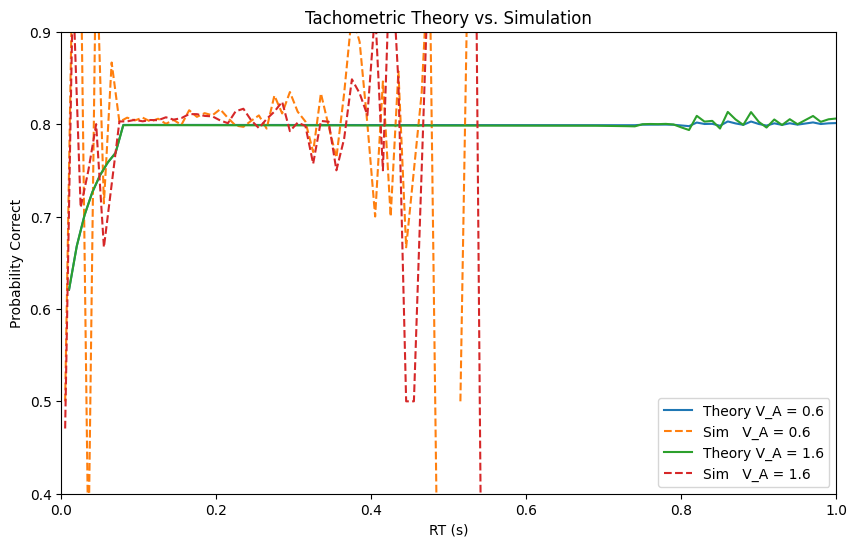

In [20]:
plt.figure(figsize=(10, 6))

for V_A in V_A_vals:
    # -------------------------
    # 3A) Theoretical Tachometric Curve
    # -------------------------
    t_pts = np.arange(0, 2, bin_size)
    tacho_theory = np.zeros_like(t_pts)
    for i, t in enumerate(t_pts):
        p_up = up_RTs_fit_single_t_fn(t, V_A, theta_A, ABL, ILD, rate_lambda,
                                      T_0, theta_E, Z_E, t_stim,
                                      t_A_aff, t_E_aff, t_motor, K_max)
        p_down = down_RTs_fit_single_t_fn(t, V_A, theta_A, ABL, ILD, rate_lambda,
                                          T_0, theta_E, Z_E, t_stim,
                                          t_A_aff, t_E_aff, t_motor, K_max)
        # Probability of correct is p_up / (p_up + p_down)
        denom = p_up + p_down
        tacho_theory[i] = p_up / denom if denom != 0 else np.nan

    # Plot theoretical curve
    plt.plot(
        t_pts - t_stim,
        tacho_theory,
        label=f"Theory V_A = {V_A}"
    )

    # -------------------------
    # 3B) Simulation-based Tachometric Curve
    # -------------------------
    sim_df = sim_results_dict[V_A].copy()
    # Define correctness
    sim_df['correct'] = (sim_df['ILD'] * sim_df['choice'] > 0).astype(int)
    # rt relative to stimulus onset
    sim_df['rt_wrt_stim'] = sim_df['rt'] - sim_df['t_stim']

    # Bin and compute fraction correct
    rt_max = sim_df['rt_wrt_stim'].max()
    bins = np.arange(0, rt_max + bin_size, bin_size)
    bin_centers = bins[:-1] + bin_size/2

    prob_correct = []
    for b_low, b_high in zip(bins[:-1], bins[1:]):
        mask = (sim_df['rt_wrt_stim'] >= b_low) & (sim_df['rt_wrt_stim'] < b_high)
        # Mean of 'correct' in this bin
        corr_mean = sim_df.loc[mask, 'correct'].mean()
        prob_correct.append(corr_mean)

    # Plot simulation curve (use '--' or markers to distinguish)
    plt.plot(
        bin_centers,
        prob_correct,
        '--',
        label=f"Sim   V_A = {V_A}"
    )

plt.xlabel("RT (s)")
plt.ylabel("Probability Correct")
plt.title("Tachometric Theory vs. Simulation")
plt.legend()
plt.xlim(0,1)
plt.ylim(0.4, 0.9)
plt.show()


# simulation

In [14]:
V_A_vals = [0, 10]
sim_results_dict = {}

N_sim = int(100e3)
for V_A in V_A_vals:
    print(f'V_A = {V_A}')
    sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda,\
        T_0, theta_E, 0, t_stim_arr, t_A_aff, t_E_aff, t_motor, dt) for i in tqdm(range(N_sim)))

    sim_results_valid = [res for res in sim_results if res['rt'] > res['t_stim']]
    sim_results_valid_df = pd.DataFrame(sim_results_valid)
    sim_results_dict[V_A] = sim_results_valid_df

V_A = 0


  0%|          | 0/100000 [00:00<?, ?it/s]

V_A = 10


  0%|          | 0/100000 [00:00<?, ?it/s]

# tacho sim

Text(0.5, 1.0, 'different V_A')

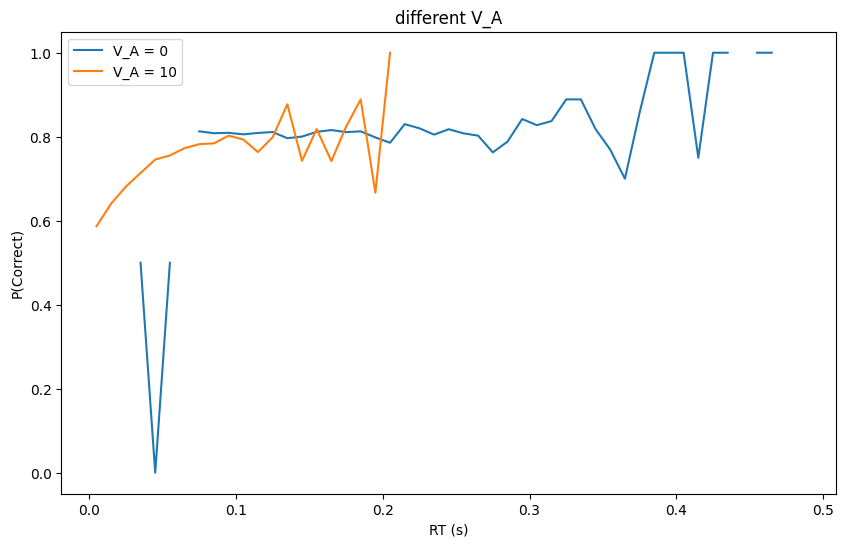

In [15]:
plt.figure(figsize=(10, 6))
for v_id, V_A in enumerate(list(sim_results_dict.keys())):
    sim_results_valid_df = sim_results_dict[V_A]
    sim_results_valid_df['correct'] = (sim_results_valid_df['ILD'] * sim_results_valid_df['choice'] > 0).astype(int)

    # Adding the "rt_wrt_stim" column
    sim_results_valid_df['rt_wrt_stim'] = sim_results_valid_df['rt'] - sim_results_valid_df['t_stim']

    bin_size = 0.01

    # Create bins for rt_wrt_stim
    bins = np.arange(0, sim_results_valid_df['rt_wrt_stim'].max() + bin_size, bin_size)

    # Calculate bin centers
    bin_centers = bins[:-1] + bin_size / 2

    # Compute probability of being correct in each bin
    prob_correct = [
        sim_results_valid_df[(sim_results_valid_df['rt_wrt_stim'] >= bins[i]) & (sim_results_valid_df['rt_wrt_stim'] < bins[i + 1])]['correct'].mean()
        for i in range(len(bins) - 1)
    ]


    plt.plot(bin_centers, prob_correct, label=f'V_A = {V_A}')

plt.legend()
plt.xlabel('RT (s)')
plt.ylabel('P(Correct)')
plt.title('different V_A')

Text(0.5, 1.0, 'Distr of valid trials')

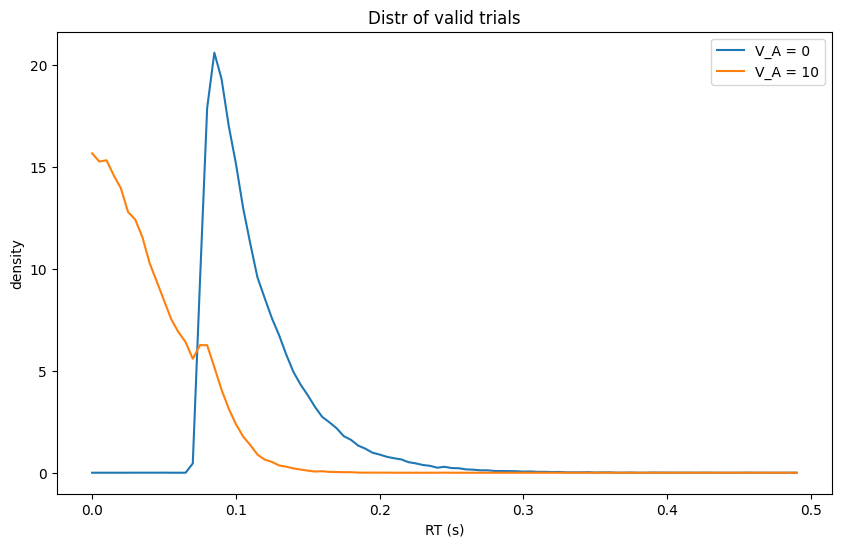

In [16]:
plt.figure(figsize=(10, 6))
for v_id, V_A in enumerate(list(sim_results_dict.keys())):
    sim_results_valid_df = sim_results_dict[V_A]
    sim_results_valid_df['correct'] = (sim_results_valid_df['ILD'] * sim_results_valid_df['choice'] > 0).astype(int)

    # Adding the "rt_wrt_stim" column
    sim_results_valid_df['rt_wrt_stim'] = sim_results_valid_df['rt'] - sim_results_valid_df['t_stim']

    bin_size = 0.005
    bins = np.arange(0, 0.5, bin_size)

    # plt.hist(sim_results_valid_df['rt_wrt_stim'], bins=bins, density=True, label=f'V_A = {V_A}', histtype='step')
    hist, _ = np.histogram(sim_results_valid_df['rt_wrt_stim'], bins=bins, density=True)
    plt.plot(bins[:-1], hist, label=f'V_A = {V_A}')
    


plt.legend()
plt.xlabel('RT (s)')
plt.ylabel('density')
plt.title('Distr of valid trials')

#  theory